# Kalman Filter


### Acknowledgements

[Neuromatch Academy: Computational Neuroscience](https://compneuro.neuromatch.io/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial4.html#video-2-linear-dynamical-systems)

Wolpert paper



## So, what is a Kalman Filter? 


In [77]:
# imports
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import transforms
from collections import namedtuple
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# figure settings
#@title Figure Settings
import ipywidgets as widgets       # interactive display
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
import matplotlib.font_manager as font_manager

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'DejaVu Sans', 'size':'18', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'DejaVu Sans', 'size':'16'}


# plt.rcParams["figure.figsize"] = (30,30)
# plt.rcParams.update({'font.size': 22})



#%config InlineBackend.figure_format = 'retina'
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [78]:
%matplotlib inline

In [167]:
#@title Helper functions
#np.set_printoptions(precision=3)

def visualize_manipandulum(s, T):
    plt.plot(s, color='limegreen', lw=2)
    plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
    plt.xlabel('Time t')
    plt.ylabel('s(t)')

def plot_measurement(s, m, T):
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(s, color='limegreen', lw=2, label='true values')
    plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
    plt.plot(m, '.', color='crimson', lw=2, label='measurements')
    plt.xlabel('Time t', **axis_font)
    plt.ylabel('s(t)', rotation=0, **axis_font)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    #plt.legend()
    
def compare(s, m):
    """ Compute a scatter plot
    Args:
    s (ndarray): arm's true position over time
    m (ndarray): arm's measured position over time 

    """
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    sbounds = 1.1*max(max(np.abs(s[:,0])), max(np.abs(m[:,0])))
    ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
    ax.set_xlabel('state', **axis_font)
    ax.set_ylabel('measurement', **axis_font)
    ax.tick_params(axis='y', rotation=45)
    ax.set_aspect('equal')

    # true state versus measurements
    plt.scatter(s, m, marker='.', color='red', s=100)
    
    
def plot_mykalman(state, observation, estimate=None, label='filter', color='r-', title='KF'):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(state, color='limegreen', lw=2, label='true values')
    plt.plot([T], [state[-1]], marker='o', markersize=8, color='limegreen')
    plt.plot(observation, '.', color='crimson', lw=2, label='measurements')
    plt.plot(estimate, '.', color='blue', lw=2, label='kf-filter')
    plt.xlabel('Timestep t', **axis_font)
    plt.ylabel('s(t)', **axis_font, rotation=90)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    
    
def plot_kalman(state, observation, estimate=None, label='filter', color='r-', title='LDS', axes=None):
    if axes is None:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
        ax1.plot(state[:, 0], state[:, 1], 'g-', label='true value')
        ax1.plot(observation[:, 0], observation[:, 1], 'k.', label='data')
    else:
        ax1, ax2 = axes

    if estimate is not None:
        ax1.plot(estimate[:, 0], estimate[:, 1], color=color, label=label)
        
    ax1.set(title=title, xlabel='X position', ylabel='Y position')
    ax1.legend()

    if estimate is None:
        ax2.plot(state[:, 0], observation[:, 0], '.k', label='dim 1')
        ax2.plot(state[:, 1], observation[:, 1], '.', color='grey', label='dim 2')
        ax2.set(title='correlation', xlabel='latent', ylabel='measured')
        
    else:
        ax2.plot(state[:, 0], estimate[:, 0], '.', color=color,
               label='latent dim 1')
        ax2.plot(state[:, 1], estimate[:, 1], 'x', color=color,
               label='latent dim 2')
        ax2.set(title='correlation',
              xlabel='real latent',
              ylabel='estimated latent')
    ax2.legend()

    return ax1, ax2


## STEP 0: THE SYSTEM__

For the sensorimotor system, they try to solve the coordinate transformation problem. This is when sensory signals may directly cue the location of the hand but motor outflow generally does not. For example, knowing the sequence of torques applied to the arm, does not determine its final configuration. To solve this problem: In  order to convert motor outflow into an estimate of the state of the arm, the system uses an internal model of the arm's dynamics. Specifically there are two varieties of internal models -- the ''forward models,'' which mimic the causal flow of a process by predicting its next state given the current state and motor command, and ''inverse models,'' which are anti-causal, estimating the motor command that causes a particular state transition.

In this case we use the Kalman filter, which uses the forward model to predict the state of the arm. The current state depends on the previous state governed by a linear dynamical system.

Representing the state of the arm at time $t$ as $x_t$ (a 2x1 vector of position and velocity), the system dynamic equations are written the form: 
$x_t = Ax_{t-1} + B u_t + w_t$,

where $A = \pmatrix{0,1\\0, -\beta/m}$, $B=\pmatrix{0\\1/m}$, $u_t$ is some input or control signal and $w_t$ represents the process of zero white noise.

The system has observable outputs, denoted by $y_t$, representing the proprioceptive signals (e.g., muscles spindles, joint receptors), which are linked to the hidden state $x_t$ by the linear system

$y_t = Cz_t + v_t$,

where $C$ is the identity matrix and $v_t$ is the output white noise.

The Kalman filter provides an optimal linear estimator of the state given by $$$$

Parameters $\beta$, $m$ and $u$ are chosen based on the participants mass of arm, and observed relationship between time and distance traveled. $A$, $B$ are chosen to simulate dead reckoning, and accommodate a participants tendency to overestimate the distance their arm has moved. 

-------

In general, process noise $Q$ is a tuning parameter to adjust the gain filter to smooth either more or less data. $Q$ represents the idea that the state of the system changes over time and we do not know the exact details of when/how, so we need to model them using random process noise.

$R$ measurement/observation noise. Primary purpose of Kalman filter is to minimize observation noise.

## STEP 1: USE THE LDS TO GENERATE SYNTHETIC STATES AND OBSERVATIONS.__


The code below sample both a latent space trajectory (given certain parameters) and noisy measurements.

In [168]:
# task dimensions
n_dim_obs = 2      
n_dim_state = 2
dt = 0.5           # in seconds

# initialize model parameters using Wolpert's paper
beta = 3.9                                        # Nsm^-1
mass = 4                                          # kg
# u_resistive, u_null, u_assistive = 1.3, 1.5, 1.9  # N
u = 1.3
params = {'A': np.array([[0,1],[0,-beta/mass]]),
          'Q': 0.000095 *np.eye(n_dim_state),              # state noise covariance
          'B': np.array([0,1.4/mass]),
          'C': np.eye(n_dim_state),
          'R': .00033 * np.eye(n_dim_obs),               # observation noise covariance
          'mu_0': np.zeros(n_dim_state),               # initial state mean
          'sigma_0': 0.1 * np.eye(n_dim_state)       # initial state noise covariance
#           'beta': 3.9,                            # Nsm^-1
#           'mass': 4,                                  # kg
#           'u':   1.3                              # external force (either null, resistive, assistive)
         }


In [169]:
def adjust_noise(state_noise, obs_noise):
    params['Q'] = state_noise *np.eye(n_dim_state)
    params['R'] = obs_noise *np.eye(n_dim_obs)

In [170]:
# create simulation data
def sample_lds(n_timesteps, params, seed=0):
    """ Generate samples from a Linear Dynamical System specified by the provided parameters.
    Args:
    n_timesteps (int): the number of time steps to simulate
    params (dict): a dictionary of model parameters: (A, Q, C, R, mu_0, sigma_0)
    seed (int): a random seed to use for reproducibility checks

    Returns:
    ndarray, ndarray: the generated state and observation data
    """
     
    n_dim_state = params['A'].shape[0]
    n_dim_obs   = params['C'].shape[0]
    
    # set seed
    np.random.seed(seed)

    # precompute random samples from the provided covariance matrices
    # mean defaults to 0
    mi = stats.multivariate_normal(cov=params['Q']).rvs(n_timesteps) # Q
    eta = stats.multivariate_normal(cov=params['R']).rvs(n_timesteps)# R

    # initialize state and observation arrays
    state = np.zeros((n_timesteps, n_dim_state))
    obs = np.zeros((n_timesteps, n_dim_obs))

    # simulate the system
    for t in range(n_timesteps):
        # compute state values given the time step
        if t == 0:
            state[t] = stats.multivariate_normal(mean=params['mu_0'], cov=params['sigma_0']).rvs(1)
        else:
            state[t] = params['A'] @ state[t-1] + params['B']*u + mi[t]  #include external forces
#             state[t] = params['A'] @ state[t-1]  + mi[t]  #include external forces


        # compute the observation
        obs[t] = params['C'] @ state[t] + eta[t]
    
    return state, obs

In [171]:
# steps

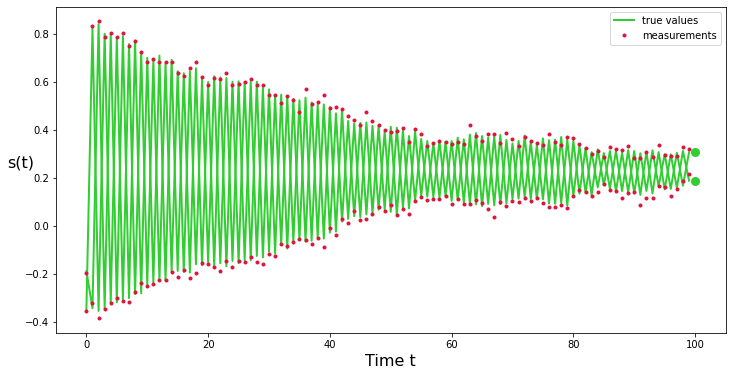

In [172]:
T = 100
state, obs = sample_lds(T, params)
plot_measurement(state, obs, T)

Manipandulum has 2 degrees of freedom (motion?). What we see is a process showing the dynamics of the system through time. Measurements are close to the actual process. After several time steps, the hand trajectories gradually become straight paths, and the end point errors decrease in size.

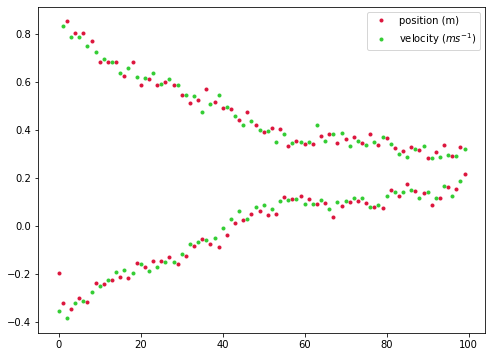

In [173]:
plt.figure(figsize=(8,6))
plt.plot(obs[:,0], '.', color='crimson', lw=2, label='position (m)')
plt.plot(obs[:,1], '.', color='limegreen', lw=2, label='velocity ($ms^{-1}$)')
plt.legend();

Compare state and measurements.

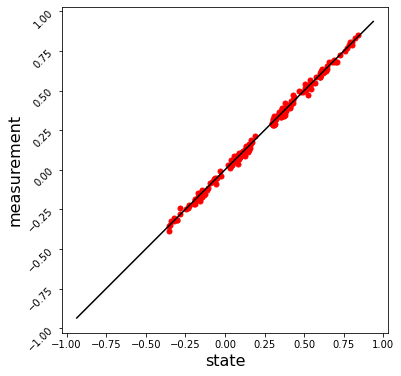

In [174]:
compare(state,obs)

Plotting state and measurements: we see the points cluster along the diagonal when the measurement noise is small. 

Adjust process noise and measurement noise.

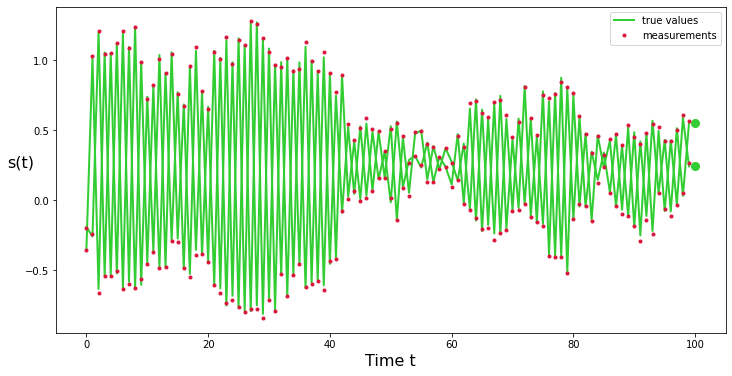

In [175]:
# increase process noise
adjust_noise(state_noise=0.0095, obs_noise=0.00033) 
state, obs = sample_lds(T, params)
plot_measurement(state, obs, T)

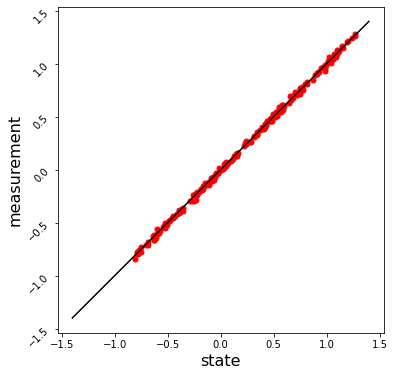

In [176]:
compare(state,obs)

Changing process noise means arm location is not predictable (?). Lots of variability in arm movements. 

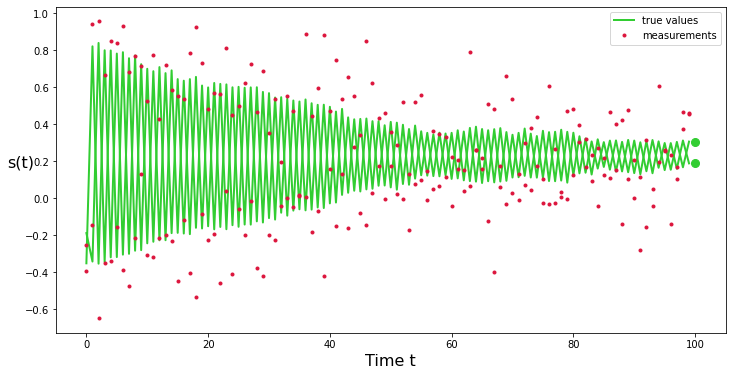

In [177]:
# state noise back to default, increase estimate noise
adjust_noise(state_noise=0.000095, obs_noise=0.033) 
state, obs = sample_lds(T, params)
plot_measurement(state, obs, T)

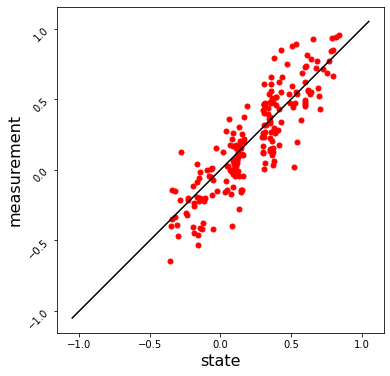

In [159]:
compare(state,obs)

When the measurement noise is $20$ times bigger, the measurements tend to be scattered, not fall on diagonal. 

Reasoning: When measurement grows big, likelihood grows. (Plot how how the posterior and likelihood change!!!) Likelihood distribution gets wider. What happens to the posterior distribution?? Does it start to resemble what the prior was???

How confident are we the measurements capture true movement of arm? Integreated the measurements, what happens???


## STEP 2: PERFORM FORWARD PASS.__

In [160]:
def kalman_filter(data, params):
    """ Perform Kalman filtering (forward pass) on the data given the provided
    system parameters.

    Args:
    data (ndarray): a sequence of observations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model parameters: (A, B, Q, C, R, mu_0, sigma_0)

    Returns:
    ndarray, ndarray: the filtered system means and noise covariance values
    """
    
    # pulled out of the params dict for convenience
    A = params['A']
    Q = params['Q']
    C = params['C']
    R = params['R']
    B = params['B']
#     u = params['u']

    n_dim_state = A.shape[0]
    n_dim_obs = C.shape[0]
    I = np.eye(n_dim_state)  # identity matrix

    # state tracking arrays
    mu = np.zeros((len(data), n_dim_state))
    sigma = np.zeros((len(data), n_dim_state, n_dim_state))

    # filter the data
    for t, y in enumerate(data):
        if t == 0:
            mu_pred = params['mu_0']
            sigma_pred = params['sigma_0']
        else:
            mu_pred = A @ mu[t-1] + B * u
            sigma_pred = A @ sigma[t-1] @ A.T + Q

        # compute the Kalman gain 
        K = sigma_pred @ C.T @ np.linalg.inv(C @ sigma_pred @ C.T + R) # KG ~ R (plot)
        # compute the filtered state mean
        mu[t] = mu_pred + K @ (y - C @ mu_pred)
        # compute the filtered state noise covariance
        sigma[t] = (I - K @ C) @ sigma_pred
        
        # bias/variance propagation???

    return mu, sigma


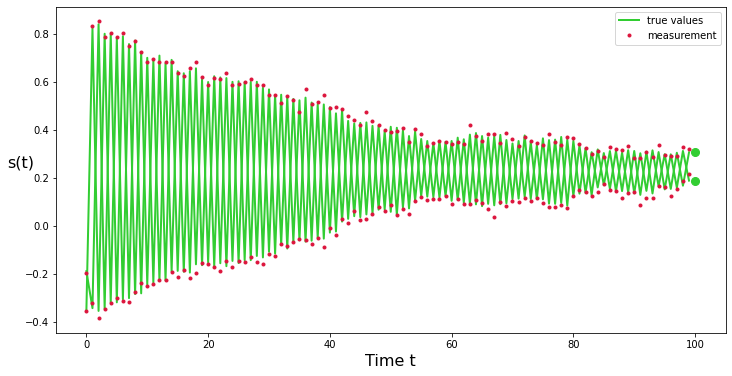

In [161]:
adjust_noise(state_noise=0.000095, obs_noise=0.00033) # set to values in paper
state, obs = sample_lds(T, params)
plot_measurement(state, obs, T)

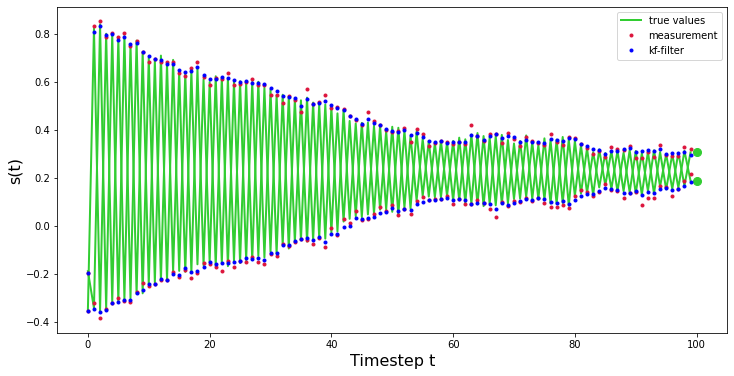

In [162]:
filtered_state_means, filtered_state_covariances = kalman_filter(obs, params)
plot_mykalman(state, obs, filtered_state_means, title="KF filter", color='r', label='estimate');

In [163]:
# plt.figure(figsize=(8,6))
# plt.plot(filtered_state_covariances[:,1], '.', color='limegreen', lw=2, label='filtered state cov')
# plt.legend();

In [164]:
# filtered_state_means

## STEP 3: PERFORM BACKWARD PASS (KALMAN SMOOTHING)__

Recursive computation of posterior probability distributions. Here we apply Bayes rule.

See the Bishop book.

In [165]:
def kalman_smooth(data, params):
    """ Perform Kalman smoothing (backward pass) on the data given the provided
    system parameters.

    Args:
    data (ndarray): a sequence of observations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model parameters: (A, B, Q, C, R, mu_0, sigma_0)

    Returns:
    ndarray, ndarray: the smoothed system means and noise covariance values
    """
    
    # pulled out of the params dict for convenience
    A = params['A']
    Q = params['Q']
    C = params['C']
    R = params['R']
    B = params['B']
#     u = params['u']

    n_dim_state = A.shape[0]
    n_dim_obs = C.shape[0]

    # first run the forward pass to get the filtered means and covariances
    mu, sigma = kalman_filter(data, params)

    # initialize state mean and covariance estimates
    mu_hat = np.zeros_like(mu)
    sigma_hat = np.zeros_like(sigma)
    mu_hat[-1] = mu[-1]
    sigma_hat[-1] = sigma[-1]

    # smooth the data
    for t in reversed(range(len(data)-1)):
        sigma_pred = A@ sigma[t] @ A.T + Q  # sigma_pred at t+1

        # compute the Kalman gain for the backward process
        K = sigma[t] @ A.T @ np.linalg.inv(sigma_pred)  # how is this different?
        # compute the smoothed state mean estimate
        mu_hat[t] = mu[t] + K @ (mu_hat[t+1] - A@ mu[t] - B*u)
        # compute the smoothed state noise covariance estimate
        sigma_hat[t] = sigma[t] + K @ (sigma_hat[t+1] - sigma_pred) @ K.T
        
    return mu_hat, sigma_hat


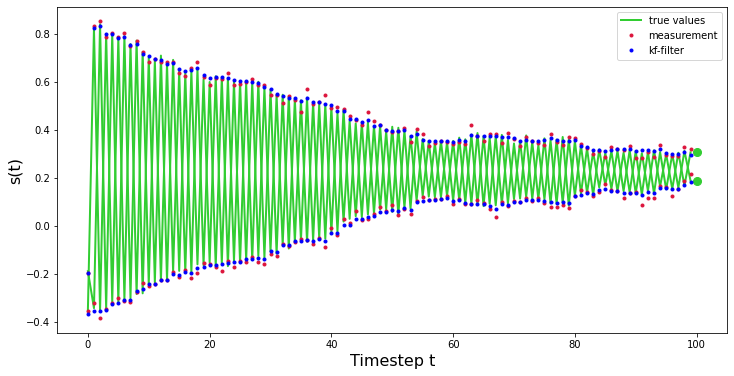

In [166]:

smoothed_state_means, smoothed_state_covariances = kalman_smooth(obs, params)

# axes = plot_kalman(state, obs, filtered_state_means, color="r",label="KF filter")

plot_mykalman(state, obs, smoothed_state_means, color="b",label="KF smoothed");

Looking at the bias and variance trade off. How do we define bias? Bias $b_i$ at time step $i$ is the expectation of the forecast error. Forecast error is the difference between the true state $x_i$ and the predicted a priori state estimate $\hat{\bar{x_i}}$ (is this during filtering??). That is $E[x_i - \hat{\bar{x_i}}]$. 

The `smoothed_state_covariances` contains covariance matrices of measurements at each time step. For each matrix, the diagonal contains the variance of the state variables (position and speed).


Now that we have implementations for both, let’s compare their performance by computing the MSE between the filtered (forward) and smoothed (backward) estimated states and the true latent state.

In [22]:
# mean squared error

filtered_mse = (state - filtered_state_means)**2
smoothed_mse = (state - smoothed_state_means)**2

print(f"Filtered MSE: {np.mean(filtered_mse):.3f}")
print(f"Smoothed MSE: {np.mean(smoothed_mse):.3f}")

Filtered MSE: 0.000
Smoothed MSE: 0.000


In [23]:
# bias
filtered_bias = filtered_state_means - obs
smoothed_bias = smoothed_state_means - obs

In [24]:
len(filtered_bias[:,0]), T

(100, 100)

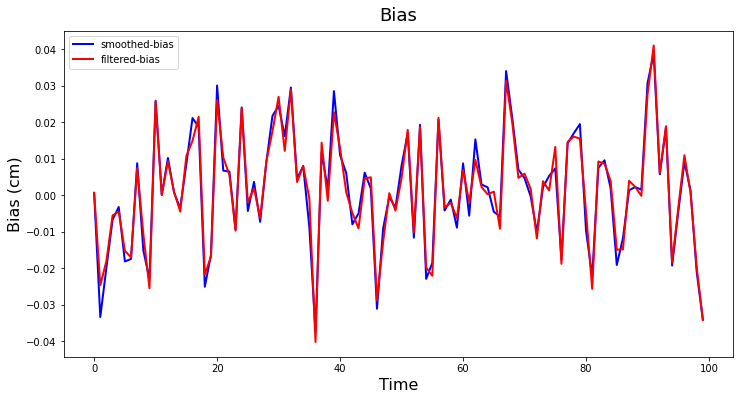

In [126]:
fig = plt.figure(figsize=(12,6))
# plt.plot(np.log(np.sqrt(smoothed_mse[:,0])), '.', color='crimson', lw=2, label='filtered-mse')
# plt.plot(smoothed_state_means[:,0], '-', color='limegreen', lw=2, label='sm mean')
plt.plot(smoothed_bias[:,0], '-', color='blue', lw=2, label='smoothed-bias')
plt.plot(filtered_bias[:,0], '-', color='red', lw=2, label='filtered-bias')

plt.title("Bias", **title_font)
plt.xlabel("Time", **axis_font)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
plt.ylabel('Bias (cm)', **axis_font)
plt.legend();



Variance

In [23]:
smoothed_state_variances = []
for var in smoothed_state_covariances:
    smoothed_state_variances.append(var.diagonal())
smoothed_state_variances = np.asarray(smoothed_state_variances)

In [24]:
filtered_state_variances = []
for var in filtered_state_covariances:
    filtered_state_variances.append(var.diagonal())
filtered_state_variances = np.asarray(filtered_state_variances)

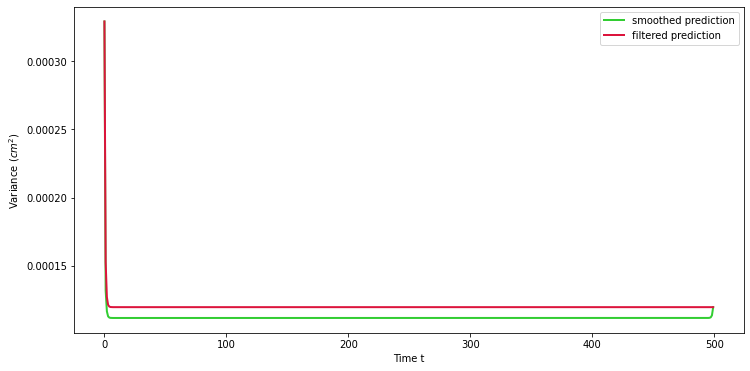

In [25]:

plt.figure(figsize=(12,6))
# plt.plot(np.log(np.sqrt(smoothed_mse[:,0])), '.', color='crimson', lw=2, label='filtered-mse')
plt.plot(smoothed_state_variances[:,0], '-', color='limegreen', lw=2, label='smoothed prediction')
plt.plot(filtered_state_variances[:,0], '-', color='crimson', lw=2, label='filtered prediction')
plt.xlabel('Time t')
plt.ylabel('Variance ($cm^2$)')
plt.legend();

In [79]:
T = 500

def simulate_experiment(n):
    """
    For each subject n, run the kalman filter and compute the bias
    Args:
    n (int): the number of participants
    Returns:
    Determine variance and bias propagation
    """
    bias = {}
    for i in range(n):
        state, obs = sample_lds(T, params)
        filtered_state_means, filtered_state_covariances = kalman_filter(obs, params)
        smoothed_state_means, smoothed_state_covariances = kalman_smooth(obs, params)
        
        filtered_mse = (state - filtered_state_means)**2
        smoothed_mse = (state - smoothed_state_means)**2
        
        bias[i] = smoothed_mse
        
    return bias

In [80]:
# do simulation 8 times to imitate the participants
simulate_experiment(8)

{7: array([[1.35973449e-04, 6.40091590e-05],
        [2.35139300e-04, 1.67612887e-05],
        [2.68525285e-04, 1.24257611e-04],
        [1.34021632e-05, 5.40734370e-05],
        [2.63052482e-05, 2.76148352e-05],
        [8.52377597e-05, 4.75806336e-08],
        [2.78040085e-05, 2.05647461e-06],
        [2.97648633e-05, 3.19177340e-06],
        [1.38861318e-04, 1.31649386e-06],
        [3.66659341e-07, 3.44375128e-06],
        [6.19334274e-04, 2.13382582e-05],
        [1.39810073e-04, 2.09138917e-04],
        [1.00865182e-06, 1.58997227e-05],
        [5.91039648e-05, 1.20402492e-05],
        [1.90881607e-05, 2.23962959e-04],
        [2.51328601e-04, 1.07527794e-04],
        [1.94050114e-04, 4.83756205e-06],
        [5.47971027e-05, 1.16573945e-06],
        [1.99953639e-05, 3.18257635e-05],
        [3.45319646e-08, 8.13117489e-05],
        [4.71558831e-04, 2.68573926e-05],
        [1.29020514e-04, 1.67568232e-07],
        [8.76009822e-05, 3.22396300e-06],
        [1.59871947e-04, 3.6781

## __STEP 4: NOW ANSWER SCIENTIFIC QUESTIONS!__

What is the bias-variance trade off?

What if we change how we generate noise?

Make table of jargon to aide understanding.


2. Clarify what variables am I inferring...

5. Compare different Kalman gain matrices, meaning, if you're navigating, how much attention are you paying to sensory feedback?

Use the Kalman gain state update equation to model the bias and variance propagation and the effects of the external forces.

In [ ]:


# params = {'A': np.array(np.array([[0, 1], [-1, 0]])),
#           'Q': np.eye(n_dim_obs),                      # state noise covariance
#           'C': np.array([[1,0],[0,1]]),
#           'R': 1.0 * np.eye(n_dim_obs),                # observation noise covariance
#           'mu_0': np.zeros(n_dim_state),               # initial state mean
#           'sigma_0': 0.1 * np.eye(n_dim_state)}        # initial state noise covariance
# params = {
#   'A': np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]]),  # state transition matrix
#   'Q': np.eye(n_dim_obs),                               # state noise covariance
#   'C': np.array([[1,0.1],[.1,1]]),                             # observation matrix
#   'R': 2 * np.eye(n_dim_obs),                       # observation noise covariance
#   'mu_0': np.zeros(n_dim_state),                        # initial state mean
#   'sigma_0': 0.1 * np.eye(n_dim_state),                 # initial state noise covariance
# }
# params = {
#   'A': 0.9 * np.eye(n_dim_state),  # state transition matrix
#   'Q': np.eye(n_dim_obs),  # state noise covariance
#   'C': np.eye(n_dim_state),  # observation matrix
#   'R': 1.0 * np.eye(n_dim_obs),  # observation noise covariance
#   'mu_0': np.zeros(n_dim_state),  # initial state mean
#   'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
# }



When do I do this? Here we estimate parameters $\Theta = \{\hat{A}, \hat{C}, \hat{Q}, \hat{R}\}$. Are we also estimating $\mu_0$ and $\Sigma_0$? This is the Kalman gain... It emerges from the EM algorithm.




The steps involved:

1) **Filter.**

$\hat{\mu}_t^{pred} = A \mu_{t-1}$

$\hat{\Sigma}_t^{pred} = A \Sigma_{t-1}A^T + Q$

2) **Projection.**

3) **Correction.** Compare our predictions to actual data, i.e., $(y_t - C \hat{\mu}_t^{pred})$, and then correct by changing the mean and covariance by a factor called the Kalman gain.

where transition matrix $A$ is the coefficient matrix that controls evolution of the latent states, with $C$ the observation matrix that specifies how observations are generated from present latent state. The noise terms have zero mean and and covariances are given by $Q$ and $R$. The LDS is stable if the eigenvalues of $A$ are bounded by one on magnitude.